# CNN model testing
Requires saved models from either:
* `cnn_mfcc.ipynb`
* `cnn_raw.ipynb`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Load audio file
song_dir = "resampled_testing_songs"
ad_dir   = "resampled_testing_ads"

song_file = 'resampled_mr_brightside.wav'
ad_file = 'resampled_2011 Heinz - bonfire night.wav'

song, song_sr = librosa.load(os.path.join(song_dir, song_file), sr=44100)
ad, ad_sr = librosa.load(os.path.join(ad_dir, ad_file), sr=44100)

print(f" song sr: {song_sr}")
print(f" ad sr: {ad_sr}")

 song sr: 44100
 ad sr: 44100


In [3]:
print(f"song shape: {song.shape}")
print(f"ad shape: {ad.shape}")

song shape: (9868037,)
ad shape: (1320474,)


In [4]:
# Define our CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(6784, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the output into a 1D vector for use in the fully connected layers
        size = x.size()[1:]  #all size except batchSize
        numFeatures = 1
        for s in size:
            numFeatures *= s
        x = x.view(-1, numFeatures)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        #x = torch.sigmoid(self.fc2(x))
        x = self.fc2(x)
        return x

In [5]:
# define get window function
def get_window(audio, begin, window_size):
    return audio[(begin):(begin+window_size)]

In [6]:
# load Model
model_name = "cnn_mfcc_model.pth"

# Load the state dictionary
state_dict = torch.load(model_name)

# Create an instance of model
model = CNN()

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Set the model in evaluation mode
model.eval()

# Initialize parameters
seconds_per_window = 5

song_win_length = 5*song_sr
song_padded = np.pad(song, (song_win_length, song_win_length), mode='constant')

ad_win_length = 5*ad_sr
ad_padded = np.pad(ad, (ad_win_length, ad_win_length), mode='constant')

window_stride = song_win_length//10

In [7]:
# evaluate song
temp = librosa.feature.mfcc(y=song[0:song_win_length], sr=song_sr, n_mfcc=13)[1:].T
mfccs = np.empty((1, 1, temp.shape[0], temp.shape[1]), dtype=np.float32)
print(f"tensor shape: {mfccs.shape}")

song_eval = []
song_confidence = []
ad_confidence = []

for i in range(0, len(song_padded) - song_win_length, window_stride):
    window = get_window(song_padded, i, song_win_length)
    mfccs[0,0] = librosa.feature.mfcc(y=window, sr=song_sr, n_mfcc=13)[1:].T
    mfccs_tensor = torch.tensor(mfccs, dtype=torch.float32)
    output = model(mfccs_tensor)
    prediction = torch.max(output.data, 1)
    song_eval.append([0 if x == 0 else 1 for x in prediction.indices])
    ad_confidence.append(output.data[0][0])
    song_confidence.append(output.data[0][1])

tensor shape: (1, 1, 431, 12)


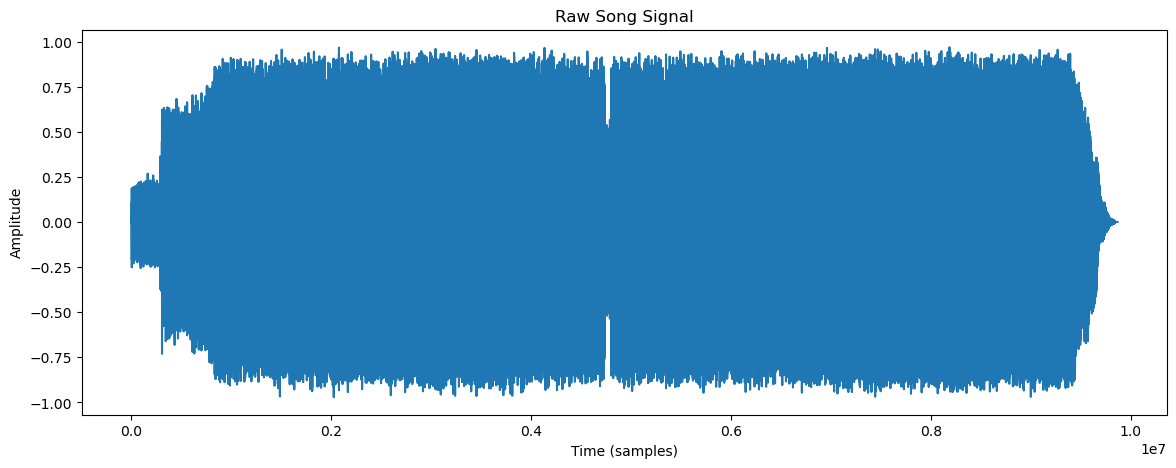

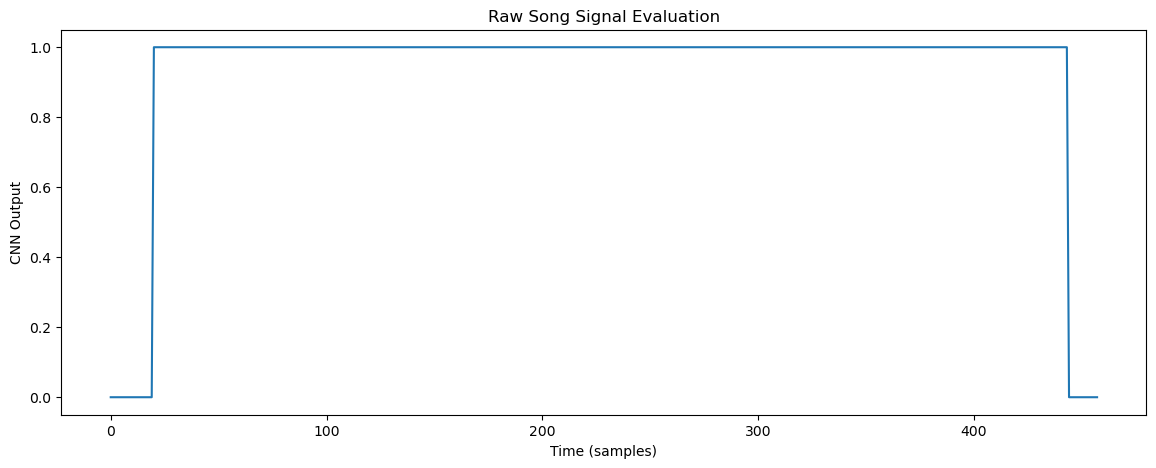

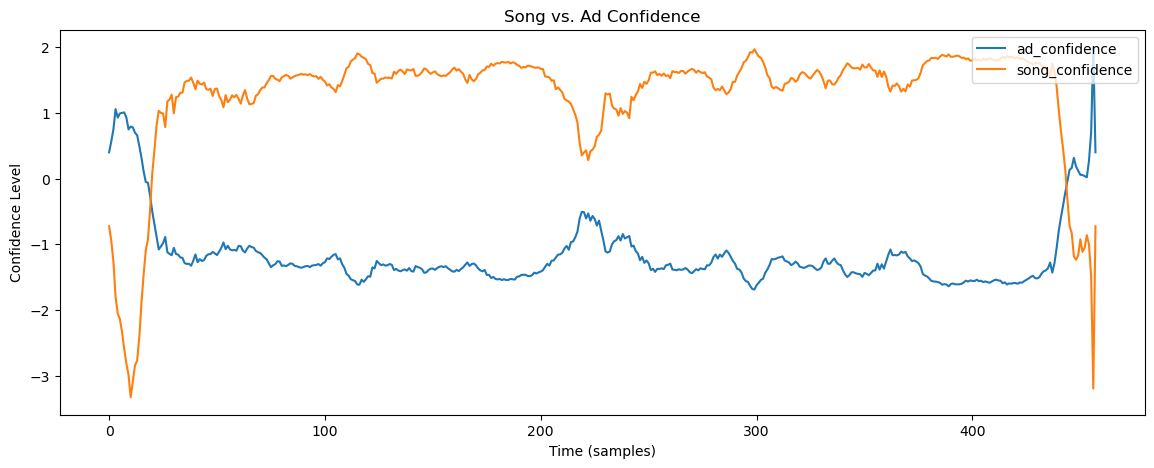

In [8]:
#plot song
plt.figure(figsize=(14, 5))
plt.plot(song)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Raw Song Signal')
plt.show()

#plot eval
plt.figure(figsize=(14, 5))
plt.plot(song_eval)
plt.xlabel('Time (samples)')
plt.ylabel('CNN Output')
plt.title('Raw Song Signal Evaluation')
plt.show()

#plot confidences
plt.figure(figsize=(14, 5))
plt.plot(ad_confidence, label='ad_confidence')
plt.plot(song_confidence, label='song_confidence')
plt.legend(loc='upper right')
plt.xlabel('Time (samples)')
plt.ylabel('Confidence Level')
plt.title('Song vs. Ad Confidence')
plt.show()

In [9]:
# evaluate ad
temp = librosa.feature.mfcc(y=song[0:song_win_length], sr=song_sr, n_mfcc=13)[1:].T
mfccs = np.empty((1, 1, temp.shape[0], temp.shape[1]), dtype=np.float32)
print(f"tensor shape: {mfccs.shape}")

ad_eval = []
song_confidence = []
ad_confidence = []

for i in range(0, len(ad_padded) - song_win_length, window_stride):
    window = get_window(ad_padded, i, song_win_length)
    mfccs[0,0] = librosa.feature.mfcc(y=window, sr=song_sr, n_mfcc=13)[1:].T
    mfccs_tensor = torch.tensor(mfccs, dtype=torch.float32)
    output = model(mfccs_tensor)
    prediction = torch.max(output.data, 1)
    ad_eval.append([0 if x == 0 else 1 for x in prediction.indices])
    ad_confidence.append(output.data[0][0])
    song_confidence.append(output.data[0][1])

tensor shape: (1, 1, 431, 12)


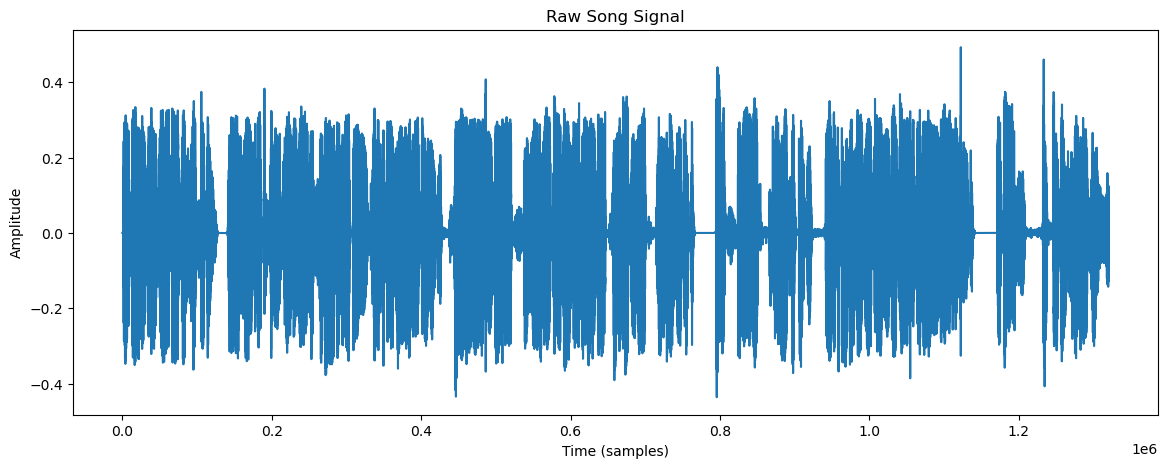

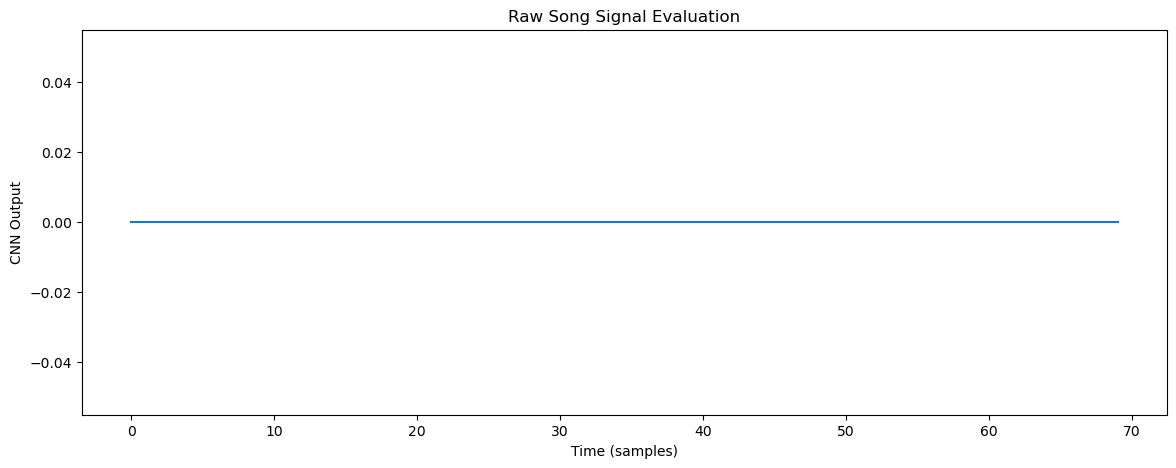

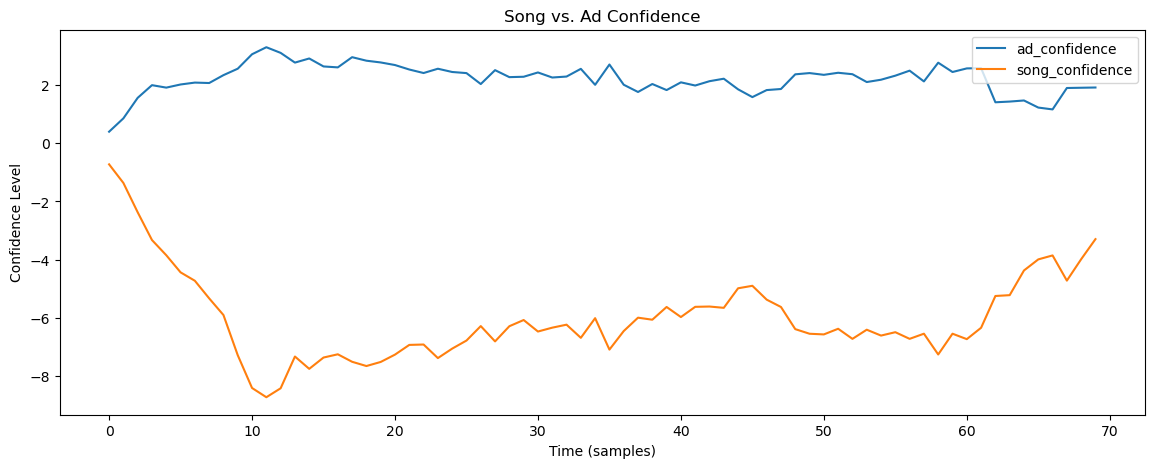

In [10]:
#plot ad
plt.figure(figsize=(14, 5))
plt.plot(ad)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Raw Song Signal')
plt.show()

#plot eval
plt.figure(figsize=(14, 5))
plt.plot(ad_eval)
plt.xlabel('Time (samples)')
plt.ylabel('CNN Output')
plt.title('Raw Song Signal Evaluation')
plt.show()

#plot confidences
plt.figure(figsize=(14, 5))
plt.plot(ad_confidence, label='ad_confidence')
plt.plot(song_confidence, label='song_confidence')
plt.legend(loc='upper right')
plt.xlabel('Time (samples)')
plt.ylabel('Confidence Level')
plt.title('Song vs. Ad Confidence')
plt.show()
